# Generate timeseries

In [7]:
!pip install dtw-python

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f_oneway
from scipy.signal import detrend
import numpy.fft as fft
from statsmodels.tsa.ar_model import AutoReg
from dtw import dtw

In [10]:
"""
GENERATING TIMESERIES
Seasonal and non-seasonal in order to validate easy examples
"""
years = 3
constant = 100
x = np.arange(0, years * 52, 1)

# Seasonal
y_s_1 = np.sin(0.125 * x) * constant + constant
y_s_2 = np.sin(0.125 * x) * constant + np.random.rand(len(x)) * (constant / 2) + constant
y_s_2[52:] += (constant / 2)
y_s_2[104:] += (constant / 2)
"""
+ np.random.rand(len(x)) * noise_strength
y[100:] += x[:100]/2 + y[100]
+ x/5 # constante
y[:100] -= 5
"""

# Non-seasonal
y_ns_1 = x
y_ns_2 = x + np.random.rand(len(x)) * constant
y_ns_3 = constant + np.random.rand(len(x)) * constant
y_ns_4 = y_ns_3 + np.random.rand(1) * x


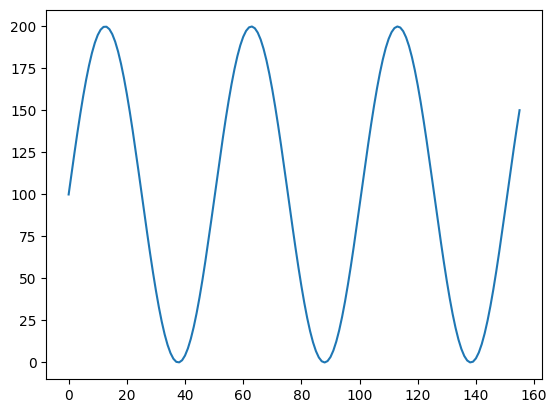

In [44]:
plt.figure()
plt.plot(x, y_s_1)

In [42]:
"""
SEASONALITY TESTS
- Tableau de Buys-Ballot
- Autocorrélation + partielle
- ANOVA (Kruskal-Wallis) : test de saisonnalité (supposé sans tendance): conditions : distribution normale, variance identique entre les groupes
- Stationnarité
- Similarité de motifs temporels avec DTW
- Méthode SAS : Entraîner 2 modèles (S et NS), comparer l'AIC puis F-test
"""

def seasonal_dtw_similarity(y: np.array, seasonal_template: np.array, season: int, lags: int or None):
  """
  1. Detrend the time series
  2. Normalize the time series
  3. Train linear model
  4. Compare DTW scores
  """
  y_detrended = detrend(y, type='linear')
  min_val = np.min(y_detrended)
  max_val = np.max(y_detrended)
  scaled_y = (y_detrended - min_val) / (max_val - min_val)
  ns_model = AutoReg(scaled_y, lags=lags).fit()
  s_alignment = dtw(scaled_y, seasonal_template, keep_internals=True)
  #s_alignment.plot(type="threeway")
  #print(s_alignment.distance)
  ns_alignment = dtw(ns_model.predict(), seasonal_template, keep_internals=True)
  #ns_alignment.plot(type="threeway")
  #print(ns_alignment.distance)
  if ns_alignment.distance < s_alignment.distance:
    return 'N'
  else:
    # F-test
    return anova_test(y, season=season)

def SAS_test(y: np.array, season: int, lags: int or None):
  """
  Source: https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html
  This attribute classifies time series as seasonal (Y), not seasonal (N), or if seasonality cannot be determined (ND).
  The seasonality threshold is seasonality + 9.
  If the time series length is less than or equal to the seasonality threshold, then seasonality is ND.
  The remaining time series are fit with two AR(1) models, one with a seasonal dummy and one without. Seasonality is N if one of the following are true:
  The AR(1) model without the seasonal dummy has a smaller AIC than the model with the seasonal dummy
  The AR(1) model without the seasonal dummy has an F-test statistic of 0.05 or better.
  The remaining time series are classified as seasonal (Y).
  """
  # TODO : DETREND ?? Or allow trend in AutoReg models
  # Train seasonal model
  s_model_res = AutoReg(y, lags=lags, seasonal=True, period=season).fit()
  #s_model_res.plot_predict()
  #print(s_model_res.aic)
  # Train non-seasonal model
  ns_model_res = AutoReg(y, lags=lags).fit()
  #ns_model_res.plot_predict()
  #print(ns_model_res.aic)
  if ns_model_res.aic < s_model_res.aic:
    return 'N'
  else:
    # F test
    return anova_test(y, season=season)

def autocorrelation_test(y: np.array, season: int):
  acorr = sm.tsa.acf(y, nlags=y.shape[0])
  #plt.figure()
  #plt.plot(acorr)
  spectrum = fft.fft(acorr)
  freq = fft.fftfreq(len(spectrum))
  #plt.plot(freq, abs(spectrum))

  # Get main frequence and infer period
  spectrum = abs(spectrum)
  main_freq = freq[np.argmax(spectrum[:int(spectrum.shape[0] / 2)])]
  period = int(1 / main_freq)

  if period == season:
    return 'Y'
  #print(f"period = {period} != {season}")
  return 'N'


def buys_ballot_table(y: np.array, season: int):
  """
  Simple test, only test hard-seasonality
  """
  # Reshape as weeks per year
  y_reshaped = y.reshape((int(y.shape[0] / 52), 52))
  samples = []
  for i in range(y_reshaped.shape[0]):
    detrended = detrend(y_reshaped[i], type='linear')
    samples.append(detrended)
  # Reshape as trimesters per year
  samples = [s.reshape(4, 13) for s in samples]
  samples = [np.sum(s, axis=1) for s in samples]
  # Sort values by descending order
  sorted_samples_arg = [np.argsort(s) for s in samples]
  print(sorted_samples_arg)


def anova_test(y: np.array, season: int):
  """
  source: https://blog.minitab.com/fr/comprendre-lanalyse-de-la-variance-anova-et-le-test-f
  scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

  Conditions : distribution normale, variances similaires
  Amélioration : detrend
  ERREUR : traiter les constantes ?? => np.nan retourné dans l'implem. Ou alors traiter les séries stationnaires en amont dans la série de tests.
  """
  # Reshape as weeks per year
  y_reshaped = y.reshape((int(y.shape[0] / 52), 52))
  samples = []
  for i in range(y_reshaped.shape[0]):
    detrended = detrend(y_reshaped[i], type='linear')
    samples.append(detrended)
  # Reshape as trimesters per year
  samples = [s.reshape(4, 13) for s in samples]
  samples = [np.sum(s, axis=1) for s in samples]
  samples = np.array(samples).transpose()
  # Compute F statistic and associated p-value
  statistic, pvalue = f_oneway(*samples)
  if pvalue >= 0.05:
    #print(f"p-value : {pvalue}")
    return 'N'
  #print(f"p-value : {pvalue}")
  return 'Y'

In [40]:
for series in [y_s_1, y_s_2]:
  print("DEBUT DES TESTS")
  print(seasonal_dtw_similarity(series, y_s_1, season=52, lags=None))
  print(SAS_test(series, season=52, lags=None))
  print(anova_test(series, season=52))
  print(autocorrelation_test(series, season=52))

DEBUT DES TESTS
Y
Y
Y
Y
DEBUT DES TESTS
Y
Y
Y
Y


In [41]:
for series in [y_ns_1, y_ns_2, y_ns_3, y_ns_4]:
  print("DEBUT DES TESTS")
  print(seasonal_dtw_similarity(series, y_s_1, season=52, lags=None))
  print(SAS_test(series, season=52, lags=None))
  print(anova_test(series, season=52))
  print(autocorrelation_test(series, season=52))

DEBUT DES TESTS
N
N
N
N
DEBUT DES TESTS
N
N
N
N
DEBUT DES TESTS
N
N
N
N
DEBUT DES TESTS
N
N
N
N


In [45]:
buys_ballot_table(y_s_2, season=52)

[array([2, 0, 3, 1]), array([2, 0, 1, 3]), array([2, 1, 0, 3])]
